In [11]:
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Reshape, Input, Concatenate, Lambda
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from tools import print_inline

import numpy as np
import matplotlib.pyplot as plt


# discriminator
def discriminator_model():
    _inp = Input(shape=(28, 28, 1), name="images")
    x = Conv2D(64, 5, strides=2, padding='same')(_inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(128, 5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(256, 5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(512, 5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    # this aaditional layers helped to converge model
    _fake = Dense(512, activation='relu')(x)
    _class = Dense(512, activation='relu')(x)
    
    _fake = Dense(1, activation='sigmoid', name="out_fake")(_fake)
    _class = Dense(10, activation='softmax', name="out_class")(_class)
    
    out = Concatenate(axis=-1)([_fake, _class])
    
    return Model(inputs=_inp, outputs=out)


def generator_model():
    _inp = Input(shape=(100,), name="noise")
    _class = Input(shape=(10,), name='class')
    
    x = Concatenate(axis=-1)([_inp,_class])
    x = Dense(1000, activation='relu')(x)
    x = Dense(7 * 7 * 256)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Reshape((7, 7, 256))(x)
    x = Dropout(0.4)(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(1, 5, padding='same')(x)
    x = Activation('sigmoid', name="out_random_image")(x)
    
    return Model(inputs=[_inp, _class], outputs=x)

def get_adversarial_model(gen,desc):
    _inp = Input(shape=(100,), name="noise")
    _class = Input(shape=(10,), name='class')
    g = gen([_inp,_class])
    d = desc(g)
    
    # model has parametr trainable, that we can use
    d.trainable = False
    model = Model(inputs=[_inp,_class], outputs=d)
    return model

def train_gan(train_steps=2000, batch_size=256, save_interval=0):
    noise_input = None
    
    discriminator = discriminator_model()
    discriminator.compile(loss=['binary_crossentropy'], optimizer=RMSprop(lr=0.0002, decay=6e-8), metrics=['accuracy'])

    generator = generator_model()
    adversarial = get_adversarial_model(generator, discriminator)
    adversarial.compile(loss=['binary_crossentropy'], optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'])

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
    y_train = keras.utils.to_categorical(y_train, 10)
    total_num = len(y_train)
    noise_main = np.random.uniform(-1.0, 1.0, size=[total_num, 100])
    classes_fake = np.array([keras.utils.to_categorical(t % 10, 10) for t in range(total_num)])
    classes_fake = classes_fake.reshape((len(y_train), 10))

    if save_interval > 0:
        noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        class_input = np.array([keras.utils.to_categorical(t % 10, 10) for t in range(16)])
        class_input = class_input.reshape((16, 10))
        

    for i in range(train_steps):
        _ids = np.random.randint(0, x_train.shape[0], size=batch_size)
        
        images_train = x_train[_ids, :, :, :]
        classes_train = y_train[_ids]
        noise_train = noise_main[_ids]
        classes_fake_train = classes_fake[_ids]
        

        images_fake = generator.predict({"noise":noise_train, "class":classes_fake_train})

        x = np.concatenate((images_train, images_fake))
        y_class = np.concatenate((classes_train, classes_fake_train))
        y_fake = np.ones([2 * batch_size, 1])
        y_fake[batch_size:, :] = 0

        out = np.concatenate([y_fake, y_class], axis=-1)
        
        d_loss, d_acc = discriminator.train_on_batch(x, out)
        
        # inverting
        y_fake = np.ones([batch_size, 1])
        _ids = np.random.randint(0, x_train.shape[0], size=batch_size)
        noise_train = noise_main[_ids]
        classes_fake_train = classes_fake[_ids]
        
        a_loss, a_acc = adversarial.train_on_batch([noise_train, classes_fake_train], np.concatenate([y_fake, classes_fake_train], axis=-1))

        log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss, d_acc)
        log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss, a_acc)
        print_inline(log_mesg)

        if save_interval > 0:
            generator.save_weights('./generator.hdf5')
            if (i + 1) % save_interval == 0:
                plot_images(generator=generator, save2file=True, samples=noise_input.shape[0], noise=[noise_input, class_input], step=(i + 1))


def plot_images(save2file=False, fake=True, samples=16, noise=None, step=0, generator=None):
    if not generator:
        generator = generator_model()
        try:
            generator.load_weights('./generator.hdf5')
        except:
            print 'No generated model'
            return
            
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
            
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            class_input = np.array([keras.utils.to_categorical(t % 10, 10) for t in range(samples)])
            class_input = class_input.reshape((16, 10))
            noise = [noise, class_input]
        else:
            filename = "data/mnist_%d.png" % step
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :].reshape(samples, 28, 28, 1)

    plt.figure(figsize=(10, 10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [28, 28])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

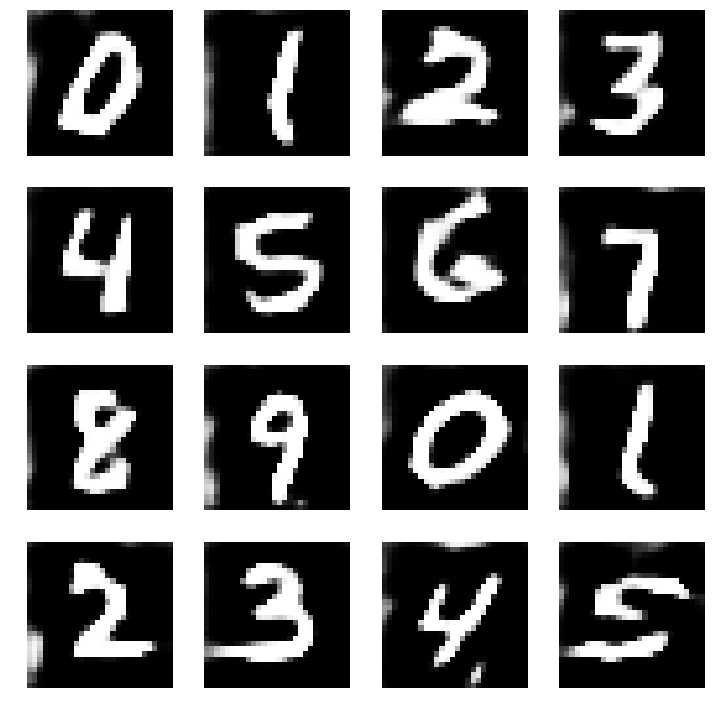

In [13]:
# train_gan(train_steps=10000, batch_size=256, save_interval=200)
plot_images(fake=True)
plot_images(fake=True, save2file=True)